## Imports

In [21]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

## Data Pre-processing
Data can be found [here](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer)

In [22]:
def load_and_flatten(directory):
    images = []
    labels = []
    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscale
                img = cv2.resize(img, (48, 48))              # Resize
                images.append(img.flatten())                 # Flatten to 1D vector
                labels.append(emotion)                       # Emotion label
    return np.array(images), np.array(labels)

# Load images from training set
X, y = load_and_flatten("train")

# Normalize pixel values to [0, 1]
X = X / 255.0

# Convert emotion strings to integers (e.g., "happy" → 0, "sad" → 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## Model Fitting

In [23]:
# Initialize K-means (7 clusters for 7 emotions)
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)

# Get cluster assignments for each image
cluster_labels = kmeans.labels_

## Predictions

In [24]:
# Create DataFrame with cluster assignments and true labels
df = pd.DataFrame({'cluster': cluster_labels, 'emotion': y_encoded})
cluster_to_emotion = {}

for cluster in range(7):
    # Get emotions in the current cluster
    cluster_emotions = df[df['cluster'] == cluster]['emotion']

    # Handle empty clusters (if any)
    if len(cluster_emotions) == 0:
        cluster_to_emotion[cluster] = -1  # Assign a placeholder (adjust as needed)
        continue

    # Extract the most common emotion using .item()
    most_common_emotion = mode(cluster_emotions).mode.item()
    cluster_to_emotion[cluster] = most_common_emotion

# Map cluster labels to emotions
predicted_emotions = [cluster_to_emotion[cluster] for cluster in cluster_labels]

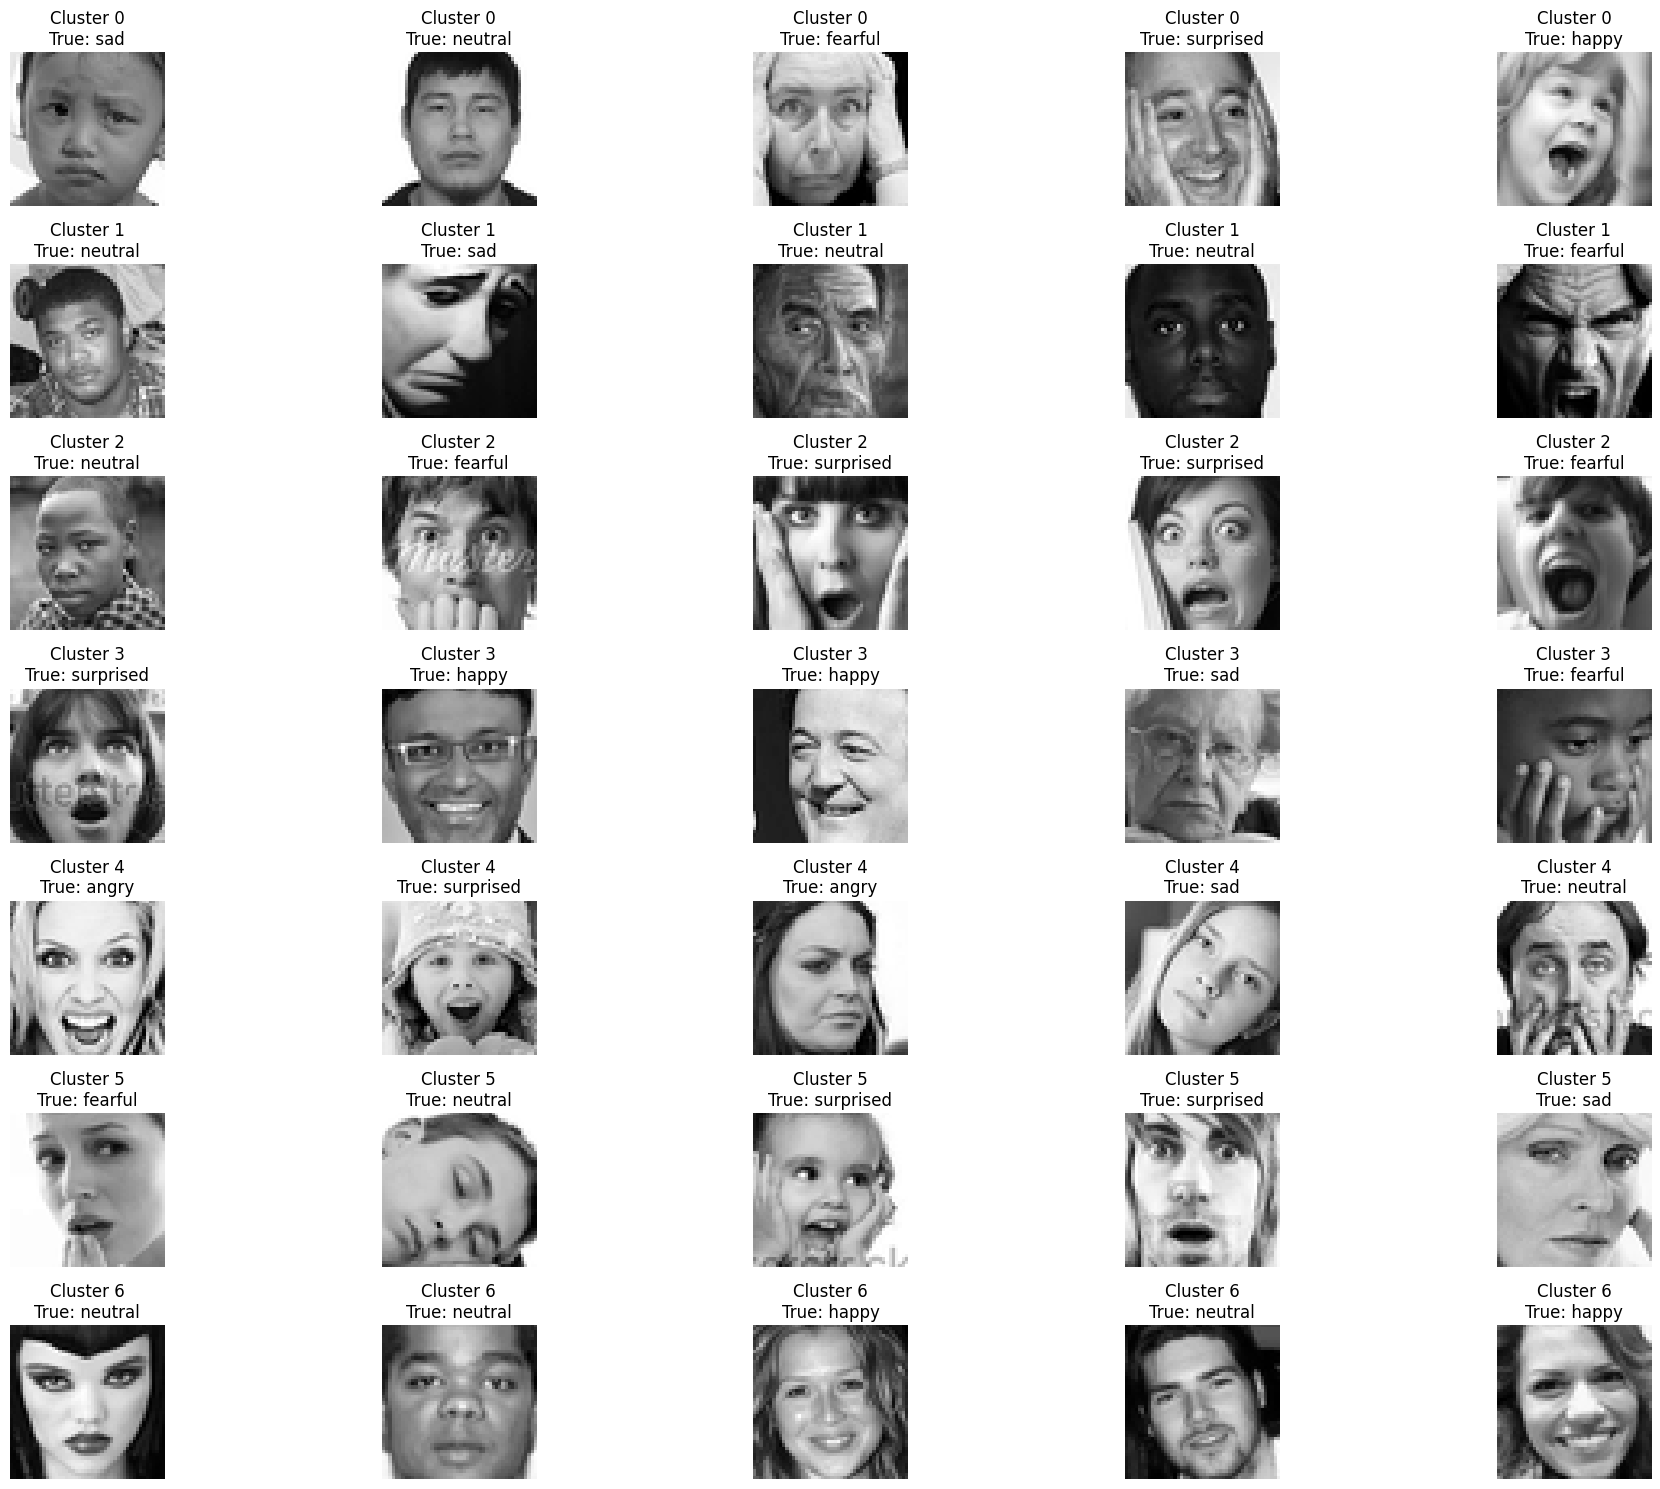

In [26]:
# Plot 5 random images from each cluster
n_samples = 5
plt.figure(figsize=(20, 15))
for cluster in range(7):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) == 0:
        continue  # Skip empty clusters
    sample_indices = np.random.choice(cluster_indices, n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        plt.subplot(7, n_samples, cluster * n_samples + i + 1)
        plt.imshow(X[idx].reshape(48, 48), cmap='gray')
        true_emotion = label_encoder.inverse_transform([y_encoded[idx]])[0]
        plt.title(f"Cluster {cluster}\nTrue: {true_emotion}")
        plt.axis('off')
plt.tight_layout()
plt.show()